Télécharger les données

In [3]:
!pip install wfdb
import wfdb
import os
wfdb.dl_database('mitdb', dl_dir='mitdb')
records = wfdb.get_record_list('mitdb')
print(records[:10], '…', len(records), 'enregistrements au total')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

## Visualisation d’un enregistrement

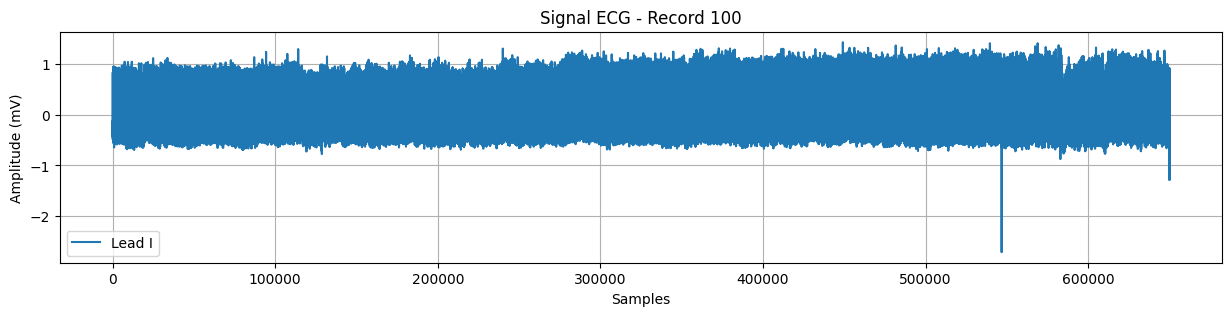

Distribution des battements :
+: 1 fois
N: 2239 fois
A: 33 fois
V: 1 fois


In [4]:
import wfdb
import os
import matplotlib.pyplot as plt
from collections import Counter

# 📁 Dossier contenant les enregistrements
data_dir = 'mitdb'

# 📄 Choix d’un enregistrement (ex. : 100)
record_name = '100'

# 🔄 Lecture du signal et des annotations
record = wfdb.rdrecord(os.path.join(data_dir, record_name))
annotation = wfdb.rdann(os.path.join(data_dir, record_name), 'atr')

# 🎨 Affichage du signal ECG (lead 1 seulement)
plt.figure(figsize=(15, 3))
plt.plot(record.p_signal[:,0], label='Lead I')
plt.title(f'Signal ECG - Record {record_name}')
plt.xlabel('Samples')
plt.ylabel('Amplitude (mV)')
plt.grid()
plt.legend()
plt.show()

# 📊 Statistiques sur les annotations
labels = annotation.symbol
count = Counter(labels)
print("Distribution des battements :")
for k, v in count.items():
    print(f"{k}: {v} fois")

## Création du dataset X et y

In [5]:
import numpy as np

# Paramètres
window_size = 200  # taille de la fenêtre autour du battement
half_window = window_size // 2
signal = record.p_signal[:, 0]  # un seul canal

X = []
y = []

for i, pos in enumerate(annotation.sample):
    if pos - half_window < 0 or pos + half_window > len(signal):
        continue  # éviter les débordements

    beat_type = annotation.symbol[i]

    # Label : 0 = normal (N), 1 = anormal (tout autre)
    label = 0 if beat_type == 'N' else 1

    # Fenêtre centrée autour du battement
    segment = signal[pos - half_window : pos + half_window]
    X.append(segment)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"{X.shape[0]} fenêtres extraites.")
print(f"Dimensions d'une fenêtre : {X.shape[1]} points")
print(f"Répartition des labels : {np.unique(y, return_counts=True)}")

2271 fenêtres extraites.
Dimensions d'une fenêtre : 200 points
Répartition des labels : (array([0, 1]), array([2237,   34]))


# Vérification visuelle

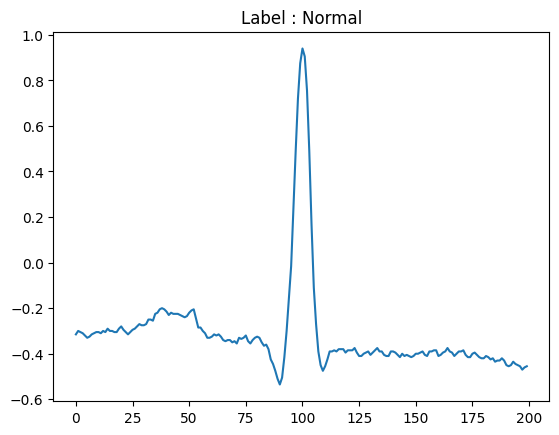

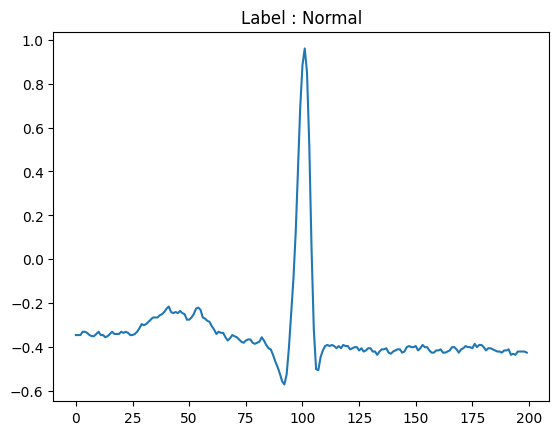

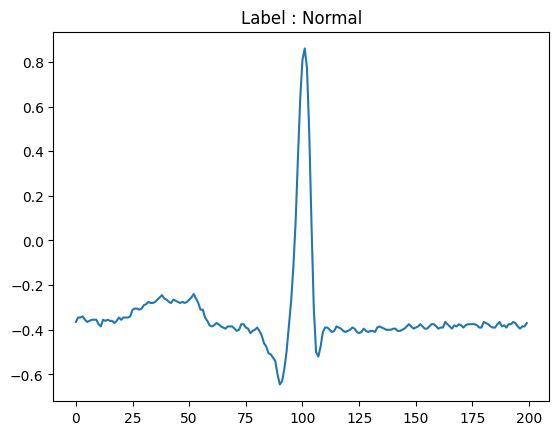

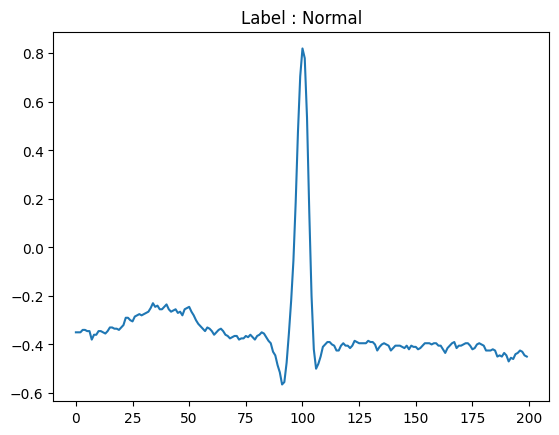

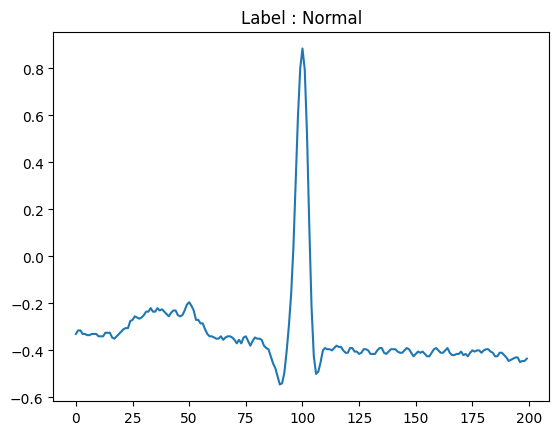

In [6]:
# Affiche quelques fenêtres avec leurs labels
import matplotlib.pyplot as plt

for i in range(5):
    plt.plot(X[i])
    plt.title(f"Label : {'Normal' if y[i]==0 else 'Anormal'}")
    plt.show()

## Étape 3 : Construction du modèle de détection d’anomalies ECG

Après avoir extrait les fenêtres autour des battements cardiaques et étiqueté chaque battement comme normal (`N`) ou anormal (tous les autres types), nous entraînons ici un modèle de machine learning supervisé.

Nous utilisons un **réseau de neurones simple (MLP)** avec une couche d'entrée prenant 200 points du signal, deux couches cachées, et une sortie binaire (0 = normal, 1 = anormal). Ce modèle apprend à distinguer des motifs typiques d’anomalies ECG à partir des segments extraits.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Construction du modèle
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binaire
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entraînement
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8580 - loss: 0.3573 - val_accuracy: 0.9780 - val_loss: 0.1579
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9887 - loss: 0.1335 - val_accuracy: 0.9780 - val_loss: 0.1467
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9870 - loss: 0.1382 - val_accuracy: 0.9808 - val_loss: 0.1280
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9877 - loss: 0.1250 - val_accuracy: 0.9808 - val_loss: 0.1149
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9899 - loss: 0.0875 - val_accuracy: 0.9780 - val_loss: 0.1066
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9828 - loss: 0.0851 - val_accuracy: 0.9808 - val_loss: 0.1003
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9903 - loss: 0.0657 - val_accuracy: 0.9780 - val_loss: 0.0876
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9876 - loss: 0.0677 - val_accuracy: 0.9835 - val_loss: 0.0869
Epo

Évaluation du modèle

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9944 - loss: 0.0200
Accuracy sur les données de test : 1.00
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       448
           1       1.00      0.71      0.83         7

    accuracy                           1.00       455
   macro avg       1.00      0.86      0.92       455
weighted avg       1.00      1.00      1.00       455



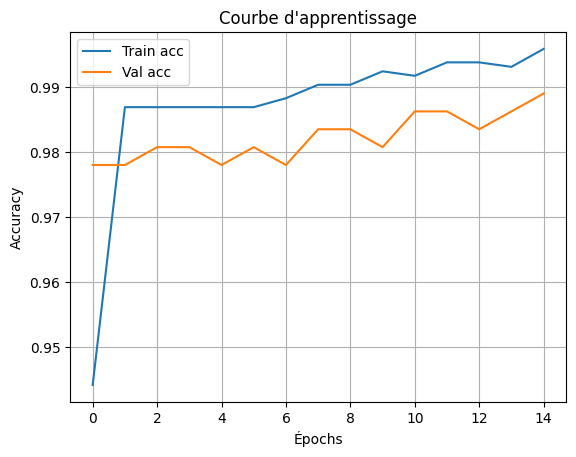

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Évaluation
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy sur les données de test : {acc:.2f}")

# Matrice de confusion
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Courbe d'apprentissage
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title("Courbe d'apprentissage")
plt.xlabel("Épochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [11]:
def predict_ecg(record_name, model, scaler, data_dir='mitdb', window_size=200):
    """
    Analyse un enregistrement ECG et prédit les anomalies avec le modèle fourni.
    """
    import wfdb
    import numpy as np
    import matplotlib.pyplot as plt
    from collections import Counter

    half_window = window_size // 2

    # Chargement du signal et des annotations
    record = wfdb.rdrecord(os.path.join(data_dir, record_name))
    annotation = wfdb.rdann(os.path.join(data_dir, record_name), 'atr')
    signal = record.p_signal[:, 0]

    X_pred = []
    labels = []
    positions = []

    for i, pos in enumerate(annotation.sample):
        if pos - half_window < 0 or pos + half_window > len(signal):
            continue
        beat_type = annotation.symbol[i]
        label = 0 if beat_type == 'N' else 1
        window = signal[pos - half_window : pos + half_window]
        X_pred.append(window)
        labels.append(label)
        positions.append(pos)

    # Prétraitement (scaling)
    X_pred = np.array(X_pred)
    X_scaled = scaler.transform(X_pred)

    # Prédiction
    y_hat = (model.predict(X_scaled) > 0.5).astype(int).flatten()

    # Statistiques
    count = Counter(y_hat)
    print(f"\n📊 Résumé des prédictions pour l’enregistrement {record_name} :")
    print(f"  - Normaux   : {count[0]} battements")
    print(f"  - Anormaux  : {count[1]} battements")
    print(f"  - Total     : {len(y_hat)} battements analysés")

    # Affichage courbe
    plt.figure(figsize=(12, 3))
    plt.plot(signal, alpha=0.6, label='Signal ECG')
    anomaly_positions = [positions[i] for i, pred in enumerate(y_hat) if pred == 1]
    plt.scatter(anomaly_positions, [signal[p] for p in anomaly_positions],
                color='red', label='Anomalies détectées', s=10)
    plt.title(f"Détection automatique des anomalies – Record {record_name}")
    plt.xlabel("Échantillons")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid()
    plt.show()


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


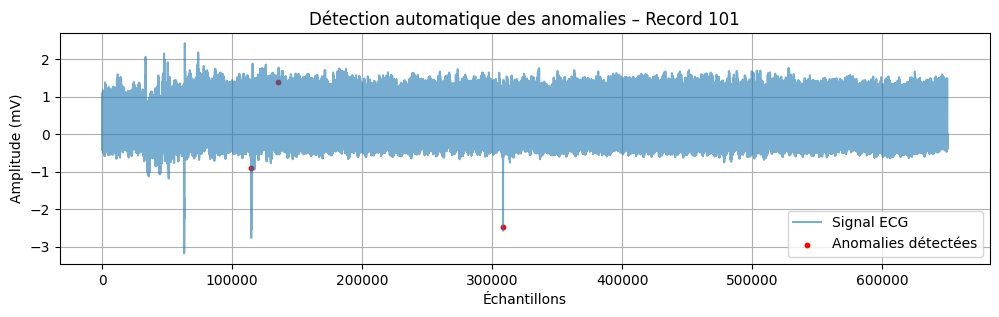

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


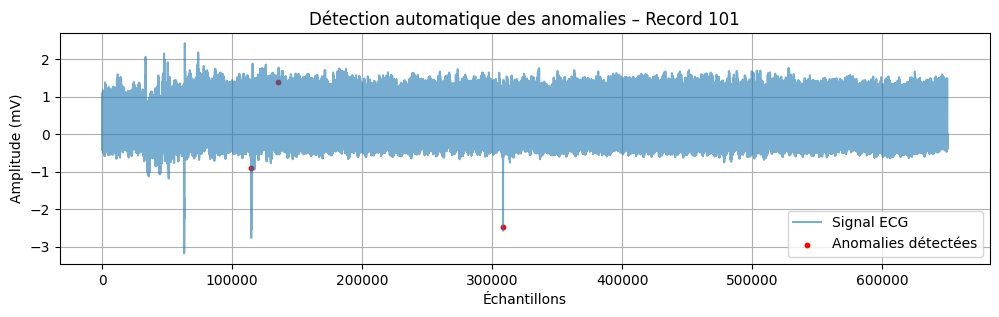

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


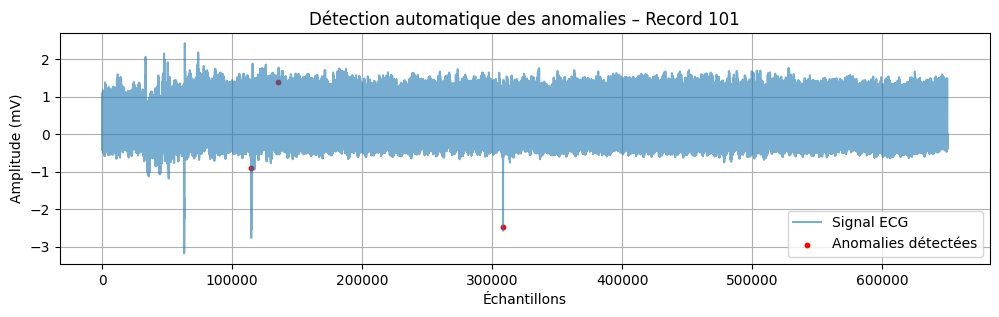

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


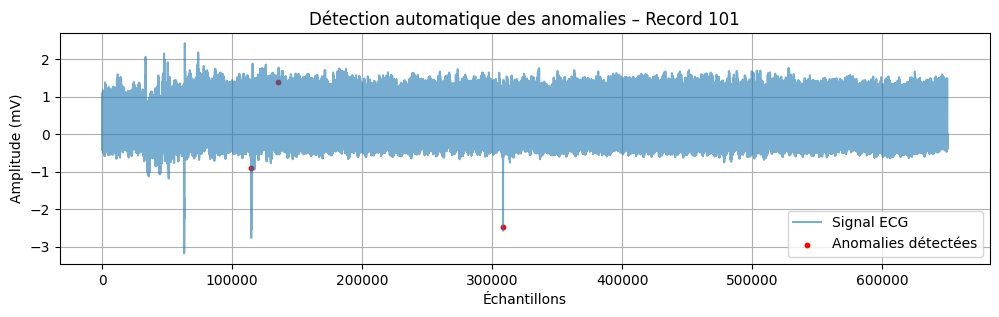

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


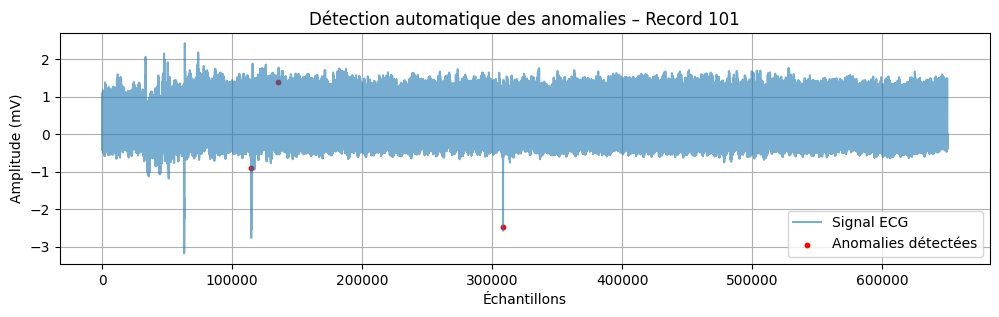

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


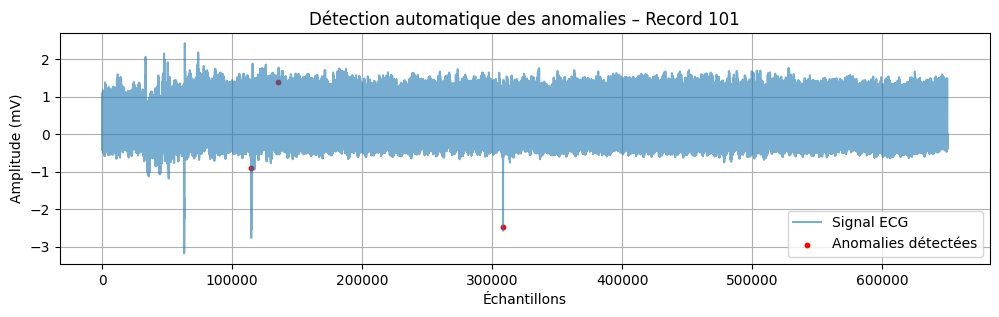

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


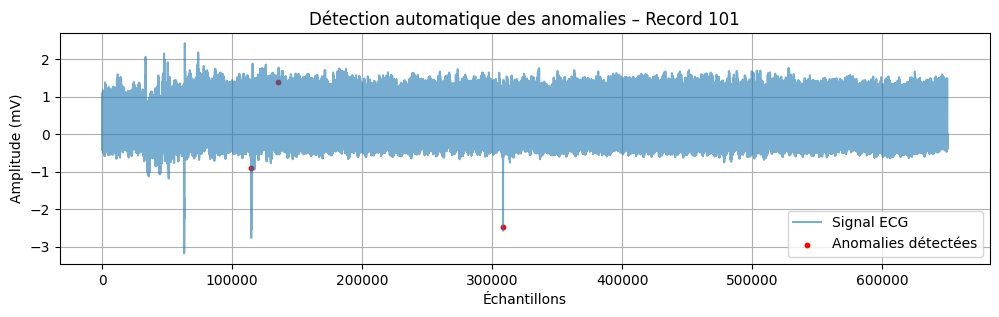

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


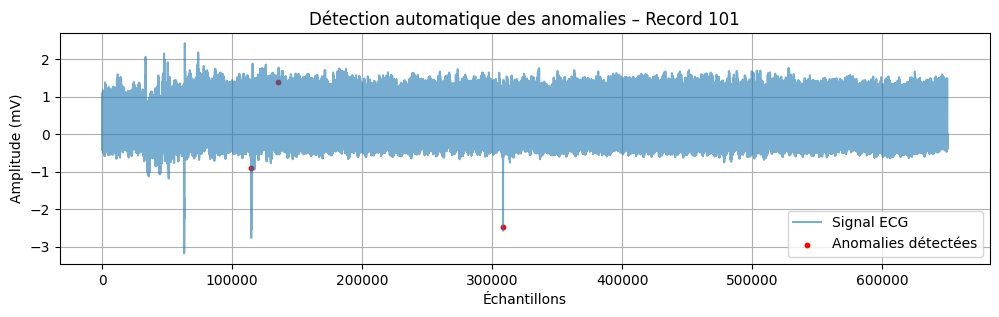

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


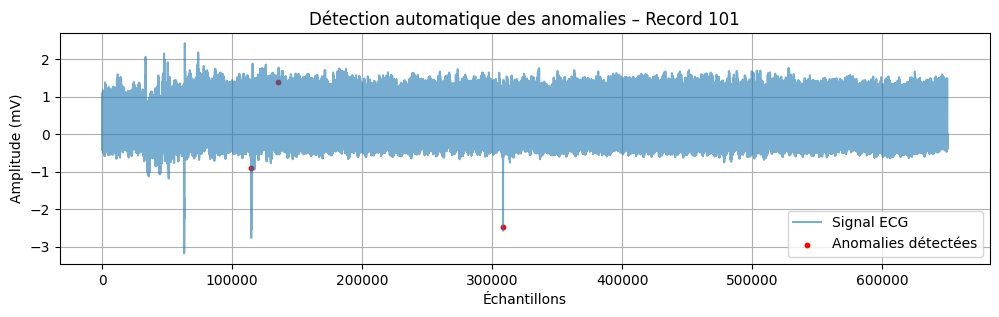

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


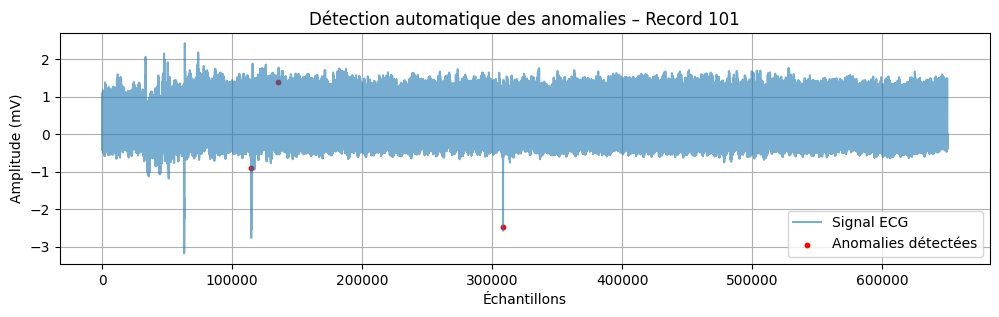

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


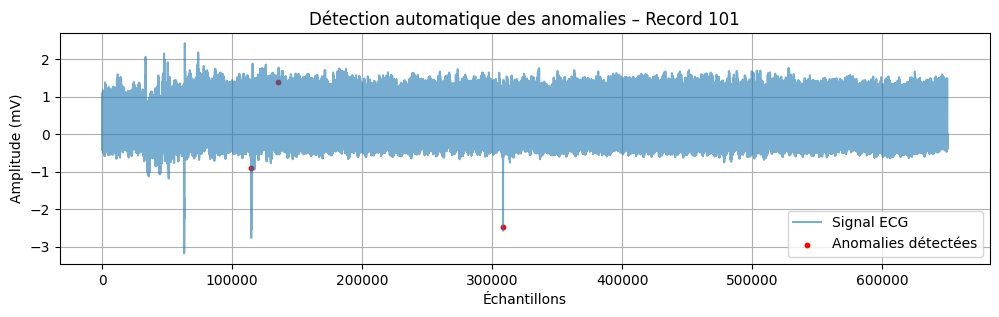

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


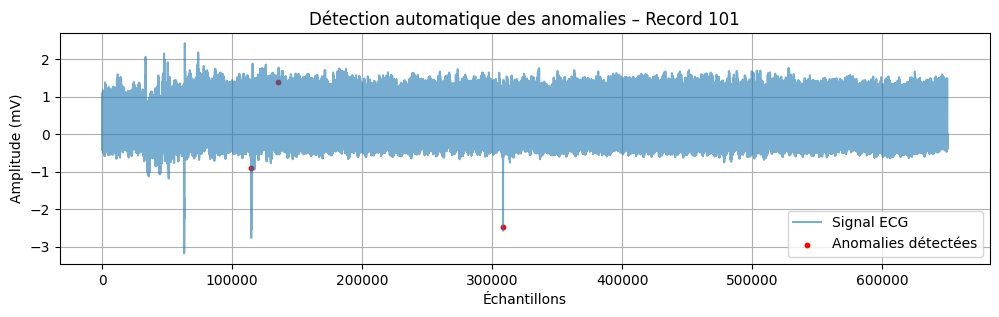

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


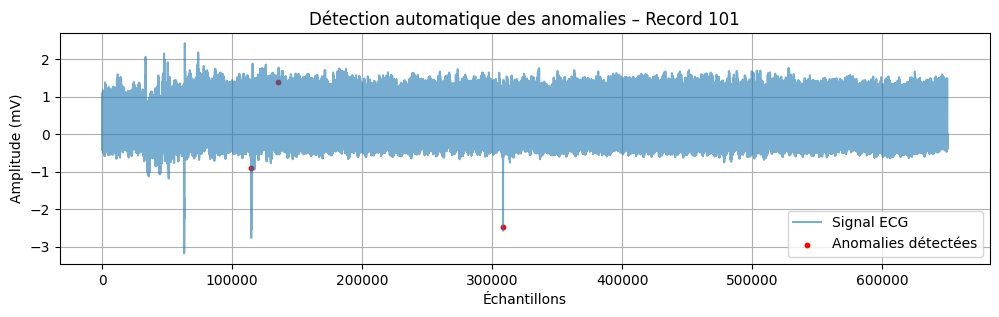

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


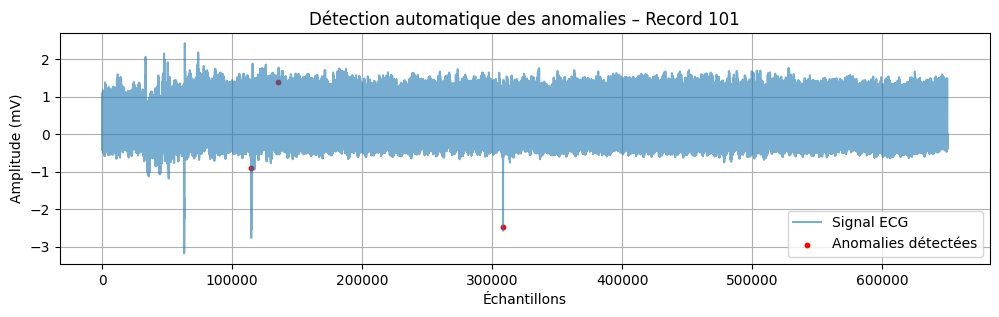

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


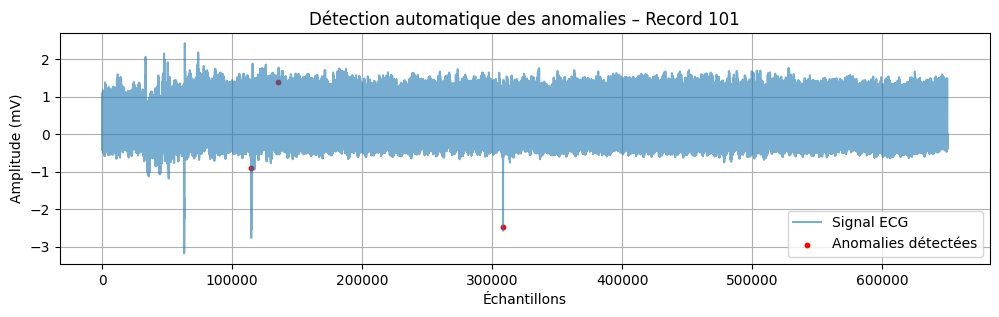

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


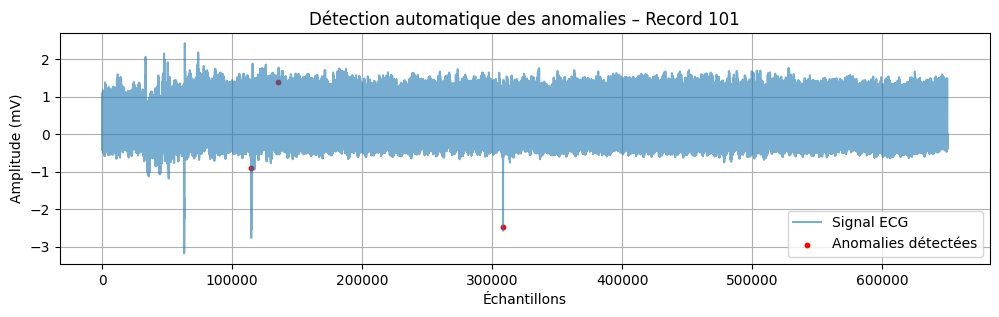

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


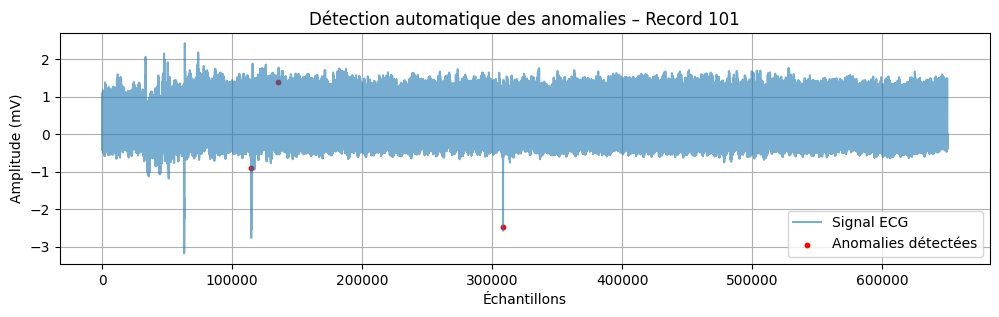

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


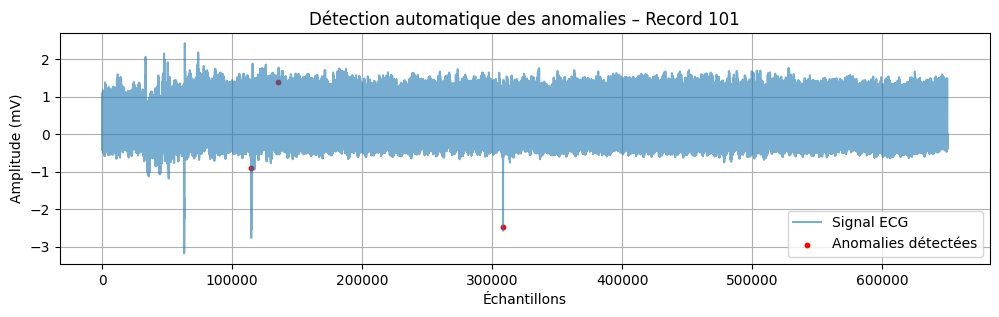

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


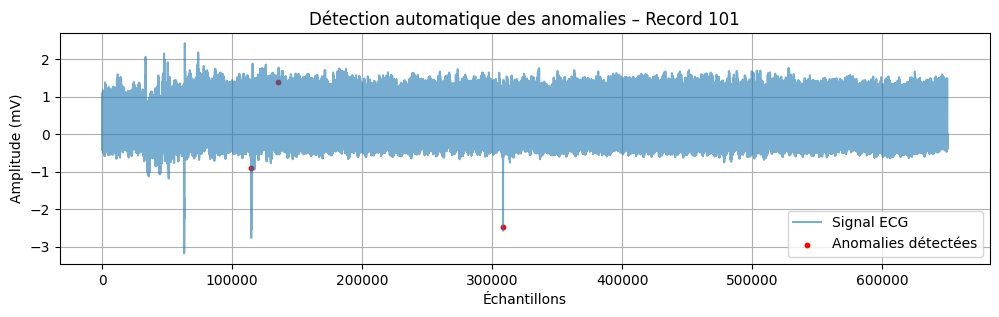

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


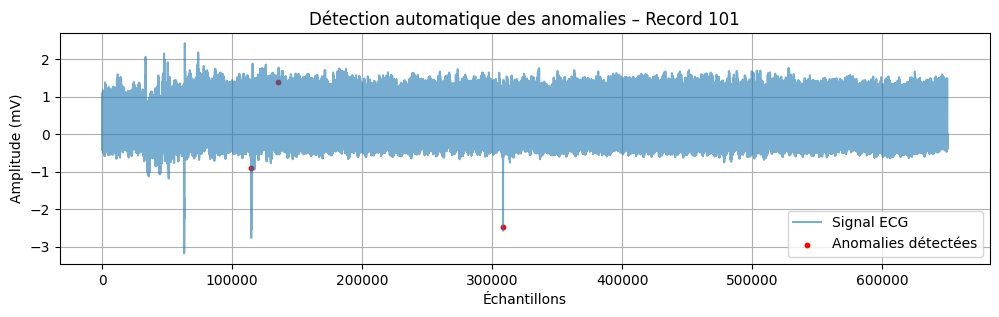

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


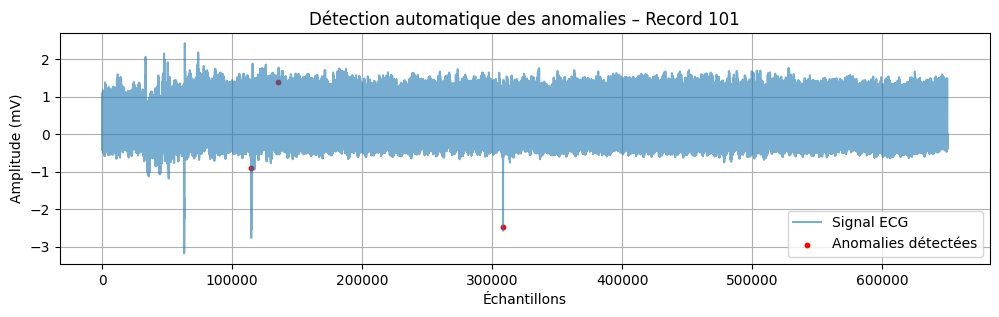

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


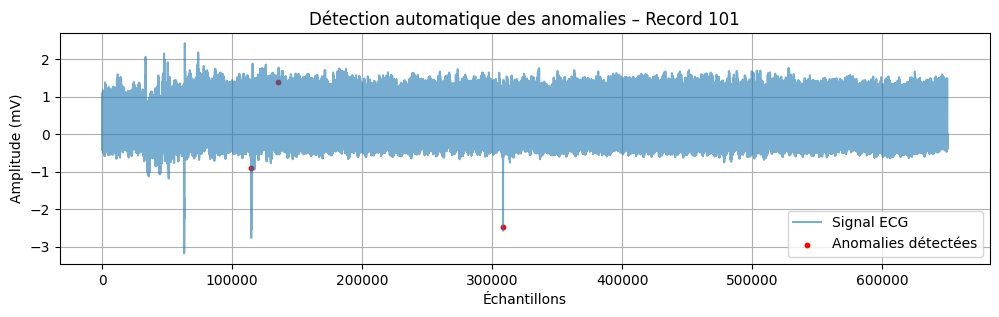

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


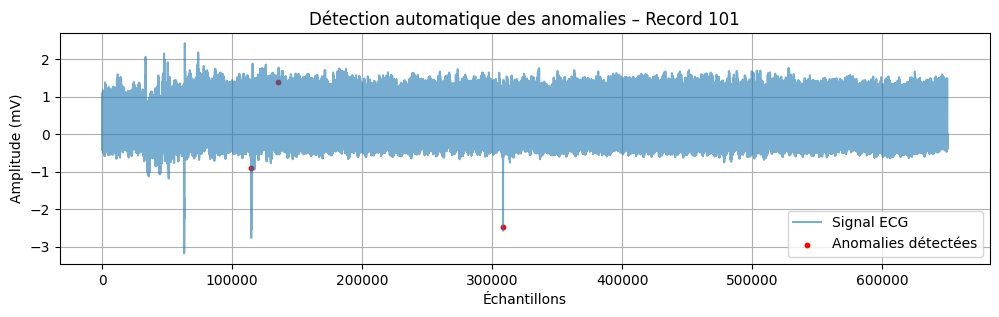

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


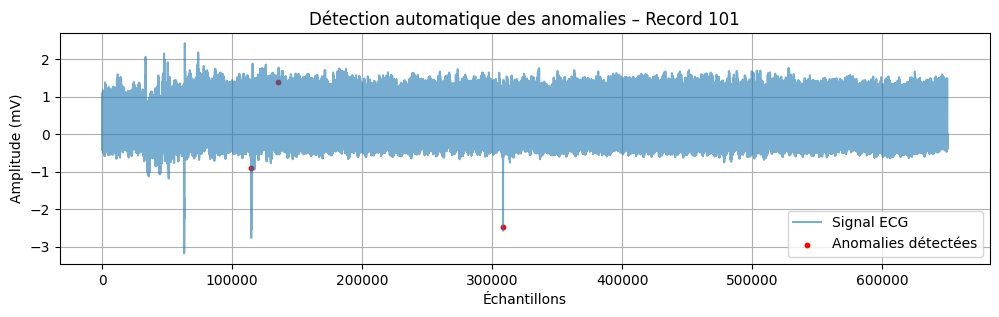

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


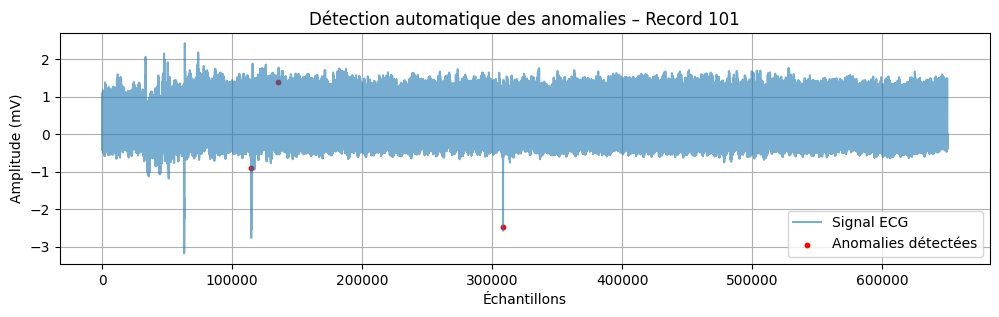

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


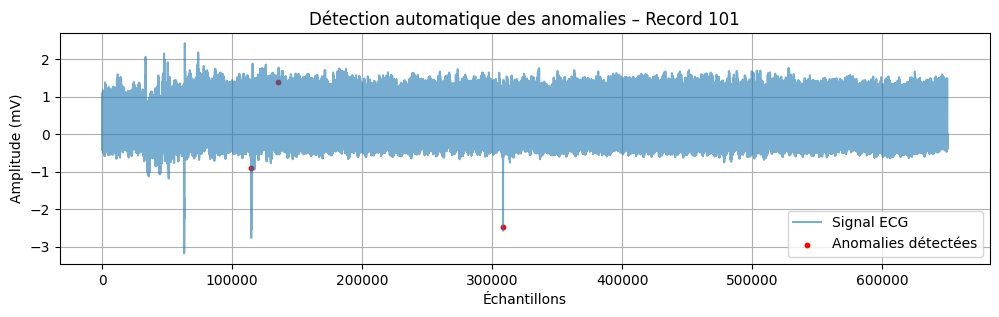

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


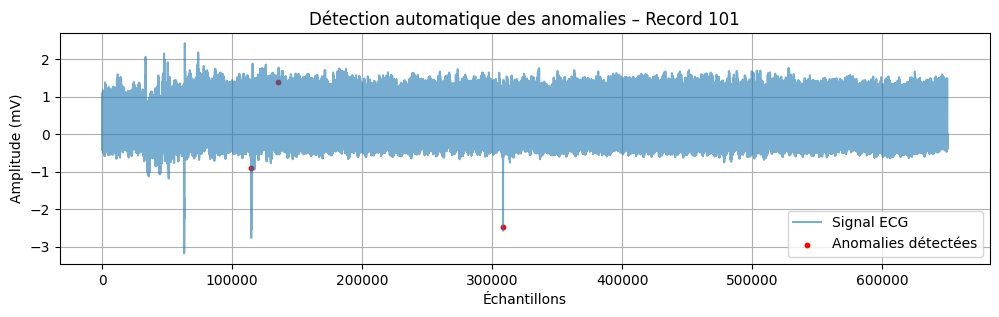

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


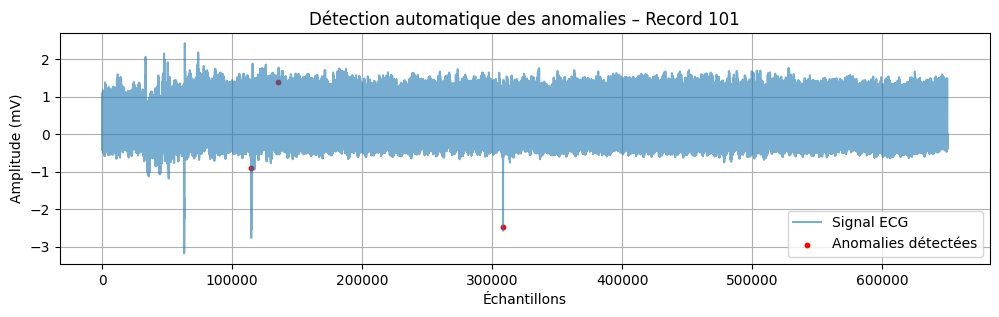

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


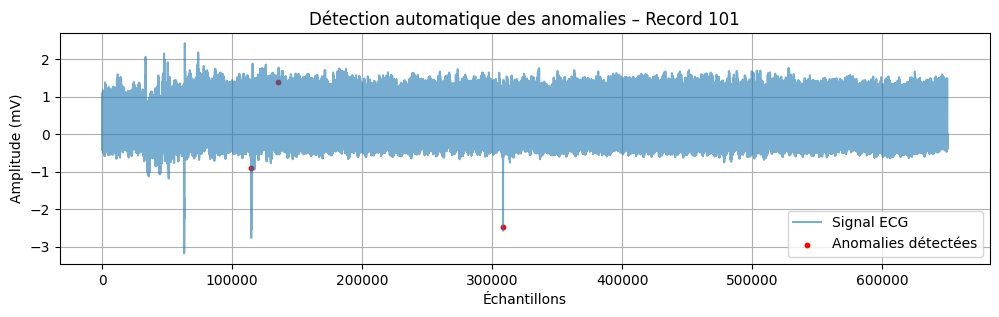

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


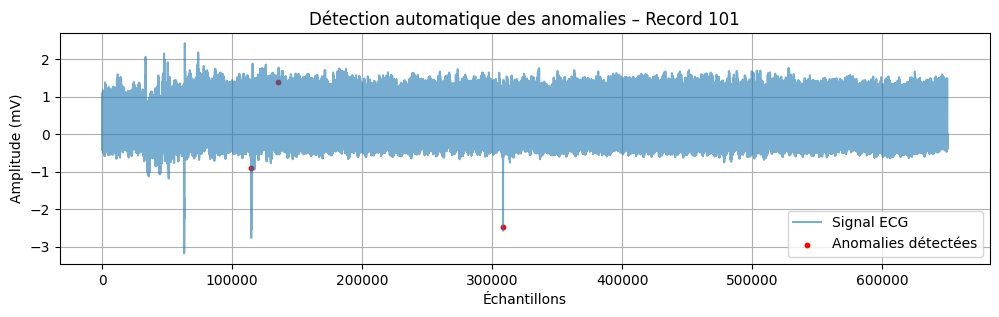

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


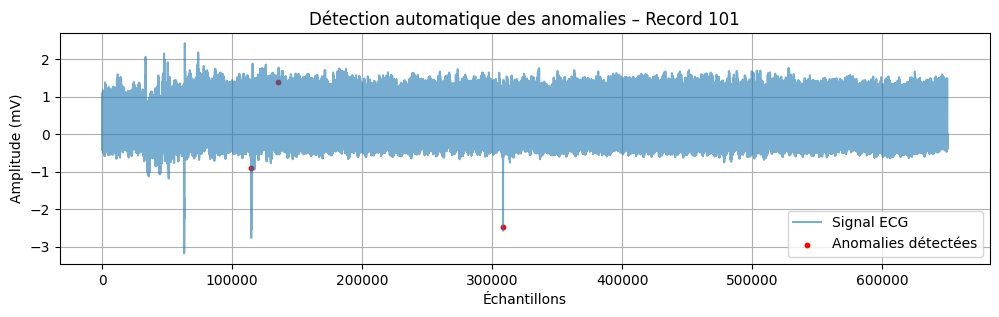

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


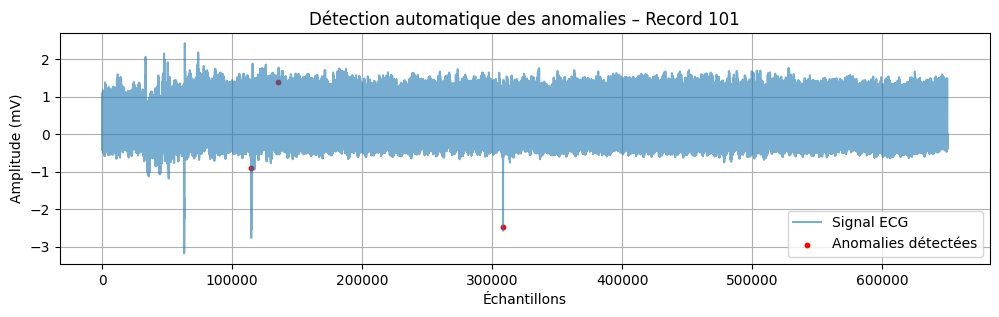

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


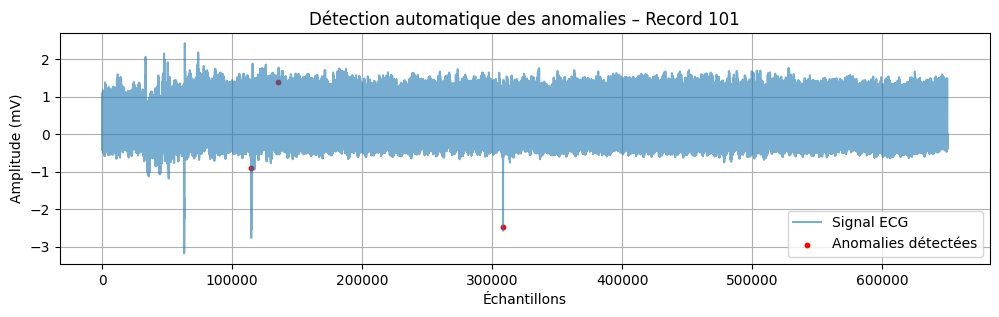

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


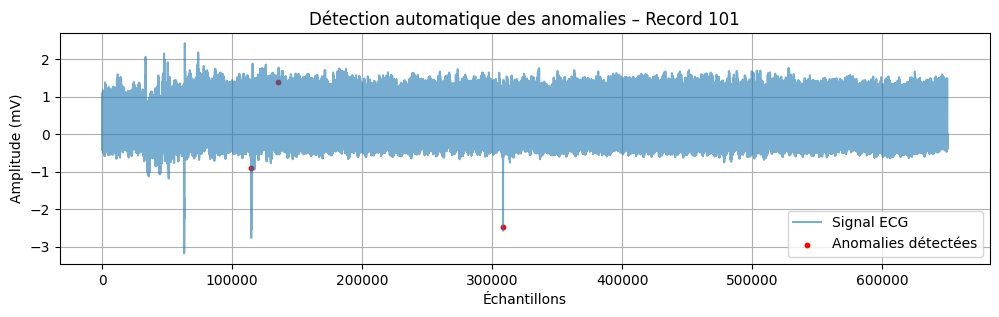

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


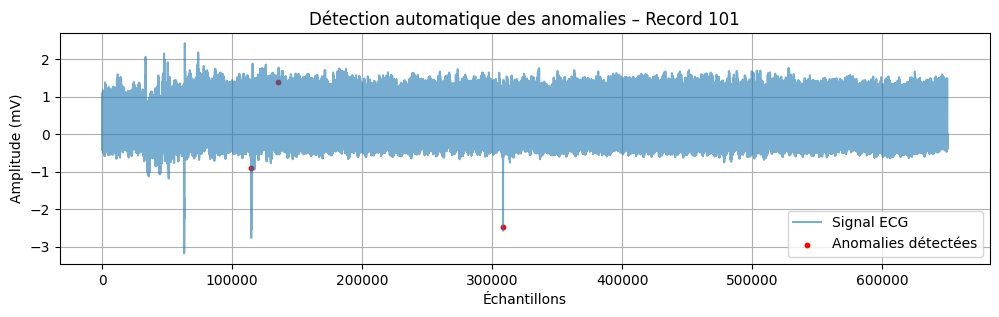

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


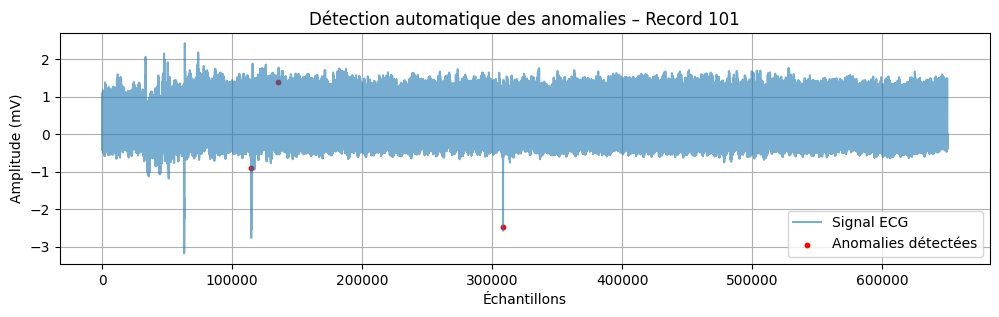

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


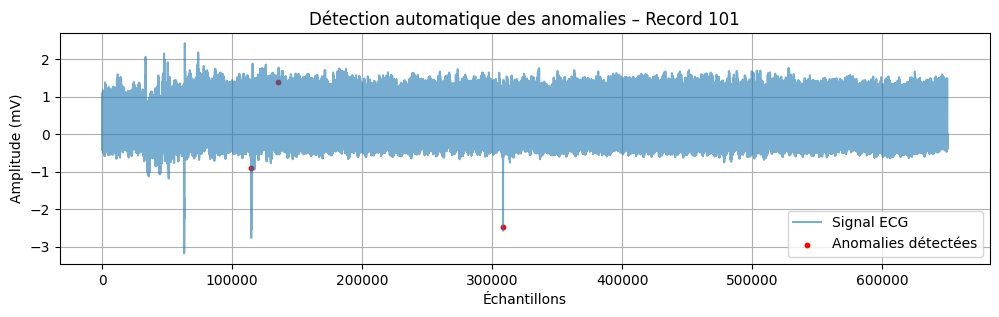

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Résumé des prédictions pour l’enregistrement 101 :
  - Normaux   : 1869 battements
  - Anormaux  : 3 battements
  - Total     : 1872 battements analysés


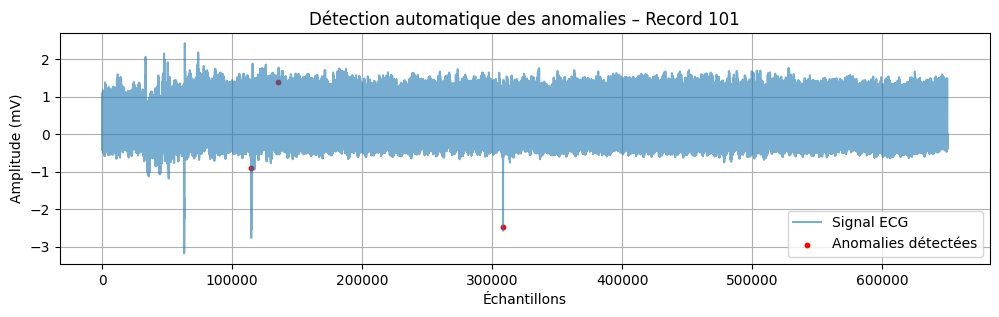

KeyboardInterrupt: 

In [12]:
    predict_ecg("101", model, scaler)

## Étape 4 : Présentation du projet – Cas d’usage

L’électrocardiogramme (ECG) est un outil de diagnostic central en cardiologie. Une analyse manuelle de plusieurs heures d’ECG (ex. : Holter 24h) est longue et sujette à l’erreur humaine. Ce projet propose une solution de classification automatique des battements cardiaques, capable de distinguer les battements normaux (N) des anomalies (extrasystoles, fibrillations, etc.) à partir du signal ECG brut.

Nous avons entraîné un modèle de machine learning (réseau de neurones multi-couches) sur des fenêtres extraites autour des battements annotés dans la base de données MIT-BIH. La prédiction sur un nouvel enregistrement est encapsulée dans une fonction `predict_ecg()` qui permet d’identifier automatiquement les anomalies et de les visualiser.

### Cas d’usage :
Un patient équipé d’un dispositif ECG portable (type Holter) produit un signal ECG continu durant 24 heures. Notre système permet d’analyser ce signal en quelques secondes et de détecter automatiquement les battements suspects, aidant ainsi le cardiologue à identifier les épisodes anormaux (arythmies, fibrillations…) sans devoir tout analyser manuellement. Cette automatisation améliore la rapidité du diagnostic et peut réduire les risques liés aux pathologies cardiaques non détectées.

Notre modèle est simple mais extensible : il peut être enrichi par d’autres enregistrements, raffiné par des modèles plus complexes (RNN, CNN 1D), et intégré dans des systèmes embarqués ou des plateformes web médicales.